# Problem Statement:

We will be investigating sexual orientation bias in the domain of sentiment anlaysis between different pretrained word embeddings, Stanford's Glove (we will be using the 200 dimensional version trained on Twitter), and the latest version of ConceptNet Numberbatch, word embeddings that take other pretrained embeddings, such as Glove, word2vec, etc. and preturb them using the distance to neighbors in the ConceptNet Knowledge graph. We feel this investigation is pertienet given the ongoing tocxicity of the Internet, twitter in particular, and may show how the choice of embeddings can affect the bias of the model, even if it is trained on the same (probably biased) data. Furthermore, with the rise of complex deep learning based language models in NLP and a shift away from interpreability and methodology, this invesdtigtion may elucidate how biases can also affect the results of relatively sophisticated models. 

Our research question is: How does the usage of different pretrained word embeddings affect sexual orientation bias in setiment analysis? 
We hypothesize that the usage of different embeddings will affect the sexual orientation bias of the resulting model to a significant extent. In particular, we believe that the Glove embeddings trained on Twitter will exacerbate the presumable existing biases in the dataset (c'mon, it's twitter) and that the ConceptNet Numberbatch embeddings will hopefully mitigate this bias.

* Saaketh
* Vedant
* Rayaan

In [223]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf
import seaborn as sns

In [2]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)
data = data[[0,5]]
data.columns = ["sentiment", "text"]

data["sentiment"] = data["sentiment"].replace(4, 1)

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["sentiment"], test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % (len(word_index)))

Found 594848 unique tokens.


In [4]:
# all of this code was taken from the last lab of the previous course

def load_embeddings(filename, embed_size):
    # the embed size should match the file you load glove from
    embeddings_index = {}
    f = open(filename)
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))

    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
        "Total words found:",found_words, "\n",
        "Percentage:",100*found_words/embedding_matrix.shape[0])
    return embedding_matrix

In [5]:
glove_embeddings = load_embeddings("glove.twitter.27B.200d.txt", 200)

Found 1193514 word vectors.
Embedding Shape: (594849, 200) 
 Total words found: 121078 
 Percentage: 20.35440927025178


In [6]:
numberbatch_embeddings = load_embeddings("numberbatch-en.txt", 300)

Found 516783 word vectors.
Embedding Shape: (594849, 300) 
 Total words found: 75671 
 Percentage: 12.721043491709661


In [7]:
X_train = pad_sequences(X_train_sequences, maxlen=30)
X_test = pad_sequences(X_test_sequences, maxlen=30)

In [15]:
MAX_ART_LEN = 30

glove_embedding_layer = Embedding(len(word_index) + 1,
                            200,
                            weights=[glove_embeddings],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
                            
numberbatch_embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[numberbatch_embeddings],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)


In [87]:
glove_rnn = Sequential()
glove_rnn.add(glove_embedding_layer)
glove_rnn.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)))
glove_rnn.add(Bidirectional(LSTM(32, dropout=0.2)))
glove_rnn.add(Dense(1, activation='sigmoid'))
glove_rnn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
glove_rnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 200)           118969800 
                                                                 
 bidirectional_11 (Bidirecti  (None, 30, 128)          135680    
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 119,146,761
Trainable params: 176,961
Non-trainable params: 118,969,800
_________________________________________________________________


In [16]:
# same model as above but with numberbatch embeddings
numberbatch_rnn = Sequential()
numberbatch_rnn.add(numberbatch_embedding_layer)
numberbatch_rnn.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)))
numberbatch_rnn.add(Bidirectional(LSTM(32, dropout=0.2)))
numberbatch_rnn.add(Dense(1, activation='sigmoid'))
numberbatch_rnn.compile(loss='binary_crossentropy',
                optimizer='adam',       
                metrics=['accuracy'])
numberbatch_rnn.summary()

2023-02-08 02:56:18.341296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 02:56:18.386053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 02:56:18.386275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 02:56:18.386938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           178454700 
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 178,682,861
Trainable params: 228,161
Non-trainable params: 178,454,700
_________________________________________________________________


In [18]:
glove_callable = keras.callbacks.ModelCheckpoint(
    filepath="glove_model.h5",
    monitor='val_accuracy',
    save_best_only=True)

numberbatch_callable = keras.callbacks.ModelCheckpoint(
    filepath="numberbatch_model.h5",
    monitor='val_accuracy',
    save_best_only=True)

In [90]:
glove_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[glove_callable])

Epoch 1/50
40000/40000 [==============================] - 246s 6ms/step - loss: 0.4180 - accuracy: 0.8063 - val_loss: 0.3852 - val_accuracy: 0.8251
Epoch 2/50
40000/40000 [==============================] - 244s 6ms/step - loss: 0.3869 - accuracy: 0.8238 - val_loss: 0.3770 - val_accuracy: 0.8301
Epoch 3/50
40000/40000 [==============================] - 246s 6ms/step - loss: 0.3776 - accuracy: 0.8295 - val_loss: 0.3730 - val_accuracy: 0.8330
Epoch 4/50
40000/40000 [==============================] - 260s 6ms/step - loss: 0.3729 - accuracy: 0.8322 - val_loss: 0.3699 - val_accuracy: 0.8338
Epoch 5/50
40000/40000 [==============================] - 258s 6ms/step - loss: 0.3698 - accuracy: 0.8339 - val_loss: 0.3686 - val_accuracy: 0.8349
Epoch 6/50
40000/40000 [==============================] - 256s 6ms/step - loss: 0.3678 - accuracy: 0.8350 - val_loss: 0.3703 - val_accuracy: 0.8348
Epoch 7/50
40000/40000 [==============================] - 257s 6ms/step - loss: 0.3661 - accuracy: 0.8356 - val_

In [19]:
numberbatch_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[numberbatch_callable])

Epoch 1/50


2023-02-08 02:56:45.245801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-08 02:56:46.041933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-08 02:56:46.043317: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f571c7c09a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-08 02:56:46.043336: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2023-02-08 02:56:46.058335: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-08 02:56:46.159757: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1.

   19/40000 [..............................] - ETA: 4:06 - loss: 0.6857 - accuracy: 0.5543  

2023-02-08 02:56:46.386412: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-08 02:56:46.392164: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-08 02:56:46.415271: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

40000/40000 [==============================] - 283s 7ms/step - loss: 0.4251 - accuracy: 0.8026 - val_loss: 0.3955 - val_accuracy: 0.8193
Epoch 2/50
40000/40000 [==============================] - 282s 7ms/step - loss: 0.3872 - accuracy: 0.8244 - val_loss: 0.3744 - val_accuracy: 0.8307
Epoch 3/50
40000/40000 [==============================] - 283s 7ms/step - loss: 0.3736 - accuracy: 0.8317 - val_loss: 0.3689 - val_accuracy: 0.8340
Epoch 4/50
40000/40000 [==============================] - 285s 7ms/step - loss: 0.3648 - accuracy: 0.8367 - val_loss: 0.3660 - val_accuracy: 0.8363
Epoch 5/50
40000/40000 [==============================] - 286s 7ms/step - loss: 0.3588 - accuracy: 0.8398 - val_loss: 0.3637 - val_accuracy: 0.8380
Epoch 6/50
40000/40000 [==============================] - 286s 7ms/step - loss: 0.3539 - accuracy: 0.8422 - val_loss: 0.3617 - val_accuracy: 0.8387
Epoch 7/50
40000/40000 [==============================] - 285s 7ms/step - loss: 0.3499 - accuracy: 0.8443 - val_loss: 0.360

### Loading the trained models from disk: 

In [9]:
glove_rnn = keras.models.load_model("glove_model.h5")
numberbatch_rnn = keras.models.load_model("numberbatch_model.h5")

In [20]:
# Returns sentiment of a sentence derived from the model
def get_sentiment(sentence, model):
    sentence = tokenizer.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen=30)
    # print model weights:
    return model.predict(sentence)

### Generating a test dataset

In [56]:
# Read in CommonNames.csv
names = pd.read_csv("CommonNames.csv")
male_names = names["Male"][:20] # Top 20 male names of the 2000s
female_names = names["Female"][:20] # Top 20 female names of the 2000s

In [383]:
lgbtq_sentence_templates = [
    "{} is gay.",
    "{}'s daughter is gay.",
    "{}'s son is gay."

]

straight_sentence_templates = [
    "{} is straight.",
    "{}'s son is straight.",
    "{}'s daughter is straight."

]

In [384]:
lgbtq_sentences = []
straight_sentences = []

for sentence in lgbtq_sentence_templates:
    for name in male_names:
        curr_sentence = sentence.format(name)
        lgbtq_sentences.append(sentence.format(name))
    for name in female_names:
        lgbtq_sentences.append(sentence.format(name))

for sentence in straight_sentence_templates:
    for name in male_names:
        straight_sentences.append(sentence.format(name))
    for name in female_names:
        straight_sentences.append(sentence.format(name))

In [398]:
glove_lgbtq = get_sentiment(lgbtq_sentences, glove_rnn)

4/4 [==============================] - 0s 2ms/step


In [397]:
glove_straight = get_sentiment(straight_sentences, glove_rnn)

4/4 [==============================] - 0s 3ms/step


In [396]:
numberbatch_lgbtq = get_sentiment(lgbtq_sentences, numberbatch_rnn)

4/4 [==============================] - 0s 3ms/step


In [409]:
numberbatch_straight = get_sentiment(straight_sentences, numberbatch_rnn)

4/4 [==============================] - 0s 3ms/step


To compare our models we will make a bar plot with 2 standard deviation error bars as well as perform an F-test on the differences to see if the populations (i.e the model output sentiments) are statstically different for each model. This test does assume the data is normally distributed and that the samples are independent from each other, which may or may not be true, but that's an issue with statistical tests in general. 

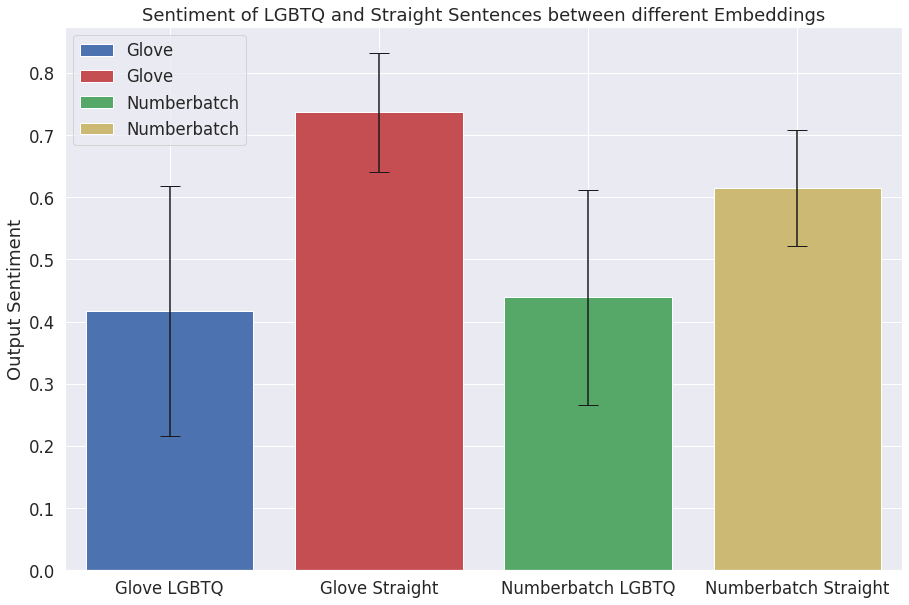

In [415]:
### Code generated with chatgpt
plt.figure(figsize=(15, 10))

plt.bar(0, np.mean(glove_lgbtq), color='b', label='Glove')
plt.bar(1, np.mean(glove_straight), color='r', label='Glove')
plt.bar(2, np.mean(numberbatch_lgbtq), color='g', label='Numberbatch')
plt.bar(3, np.mean(numberbatch_straight), color='y', label='Numberbatch')

plt.errorbar(0, np.mean(glove_lgbtq), yerr=np.std(glove_lgbtq)*2, color='k', capsize=10, fmt='none')
plt.errorbar(1, np.mean(glove_straight), yerr=np.std(glove_straight)*2, color='k', capsize=10, fmt='none')
plt.errorbar(2, np.mean(numberbatch_lgbtq), yerr=np.std(numberbatch_lgbtq)*2, color='k', capsize=10, fmt='none')
plt.errorbar(3, np.mean(numberbatch_straight), yerr=np.std(numberbatch_straight)*2, color='k', capsize=10, fmt='none')

plt.xticks([0, 1, 2, 3], ['Glove LGBTQ', 'Glove Straight', 'Numberbatch LGBTQ', 'Numberbatch Straight'])

plt.xlim(-0.5, 3.5)
plt.ylim(bottom=0)

plt.title("Sentiment of LGBTQ and Straight Sentences between different Embeddings")
plt.ylabel("Output Sentiment")
plt.legend()
plt.show()

In [417]:
# performing a f-test on the differences between the straight and lgbtq sentences for each of the embeddings
glove_diff = glove_straight - glove_lgbtq
numberbatch_diff = numberbatch_straight - numberbatch_lgbtq
 
import scipy.stats as stats
f_statistic, p_value = stats.f_oneway(glove_diff, numberbatch_diff)
print("F-statistic: ", f_statistic)
print("P-value: ", p_value)

F-statistic:  [116.83073893]
P-value:  [2.04619216e-22]


From the bar chart above, we can see that the difference in sentiment between the glove and number batch embeddings is pretty significiant, this can further be confirmed with a f-test to validate the statistical significance of the difference. The difference between Glove's straight sentiment and Glove's LGBTQ sentiment is significantly larger than the difference between Numberbatch's straight sentiment and Numberbatch's LGBTQ sentiment.

In conclusion, our analysis compared the performance of two popular embedding models, GloVe Twitter embeddings and ConceptNet Numberbatch, in training an LSTM for sentiment analysis on a large dataset of 1.6 million tweets. We further tested the models on sentences with common male and female names on sentences suggesting a straight or gay orientation. Our results showed that the two models differed significantly in their predicted sentiment for each group of sentences as evidenced by the confidnce intervals in the bar chart. These findings suggest that careful consideration must be given to the choice of embedding model in sentiment analysis tasks, particularly in scenarios where demographic factors may be important, such as gender or sexual orientation. Overall, our study highlights the importance of critically evaluating the performance of different models in NLP tasks, to ensure the most accurate and unbiased results, as well as confirming our hpothesis that numbrebatch embeddings can mitigate the bias of the model. For further analysis, we reccomend that the same analysis be performed on other pretrained embeddings, such as word2vec, extending to other tasks in NLP, using differnt architectures, such as transformers, and extending this approach to inveztigate other forms of bias, such as race, age, etc.,or even examining the bias across these factors.

Conclusion partially generated by chat-gpt :)

### Potential Publishers that may be interested in this work:


* AI Ethics Journal: This journal focuses on the intersection between Computer Science, Philosphy and Technology. Becuase our research is comparing the sexual orientation bias between two leading word embedding models, we believe that this journal would be interested in our findings.

* Empirical Methods in Natural Language Processing: This journal focuses on Natural Langauge processing research. One of the main objectives of NLP researches is to mitigate bias in their models. Our research shows how different word embeddings can have significant impacts on the amount of bias of a trained model. In our case, we showcased how different leading word embeddings had varying sentiment on the LGBTQ community relative to the straight community. We imagine other biases exist between these two embeddings and thus we showcase the importance of carefully choosing the word embeddings when building a NLP model.

